# Stereoisomer testing on ChiENN - valenztautomerie

## Importing section

In [133]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../../")

from ptgnn.features.chienn.molecule3d import smiles_to_data_with_circle_index
from ptgnn.model.chienn.chienn_layer import ChiENNLayer
from ptgnn.loading.chienn_collate import collate_with_circle_index

## Define SMILES strings

In [134]:
smiles_list = [
    "C1=CC=CC=CC=C1",
    "C1C=CC=CC=CC=1",
    "C12C=CC=CC1C=C2",
    
    "C1C=CC(Cl)=CC=C(Cl)C=1",
    "C1C=CC=C(Cl)C=CC(Cl)=1",
]

## Visualize and confirm stereomer classification (E/Z)

In [135]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

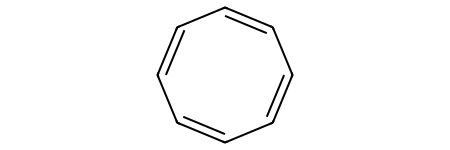

[]
Bond 0 stereo: STEREONONE
Bond 2 stereo: STEREONONE
Bond 4 stereo: STEREONONE
Bond 6 stereo: STEREONONE


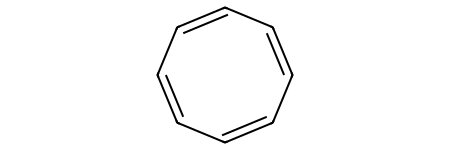

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 5 stereo: STEREONONE
Bond 7 stereo: STEREONONE


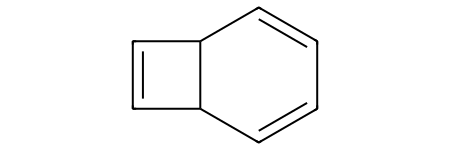

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 6 stereo: STEREONONE


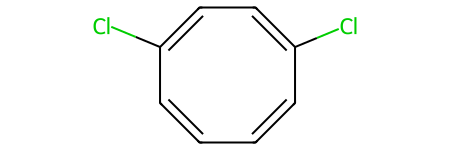

[]
Bond 1 stereo: STEREONONE
Bond 4 stereo: STEREONONE
Bond 6 stereo: STEREONONE
Bond 9 stereo: STEREONONE


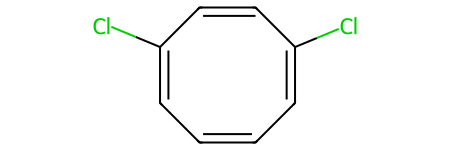

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 6 stereo: STEREONONE
Bond 9 stereo: STEREONONE


In [136]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph

In [137]:
data_list = [
    smiles_to_data_with_circle_index(smiles)
    for smiles in smiles_list
]

In [138]:
for data in data_list:
    print(data)
    print(data.circle_index)

Data(x=[32, 93], edge_index=[2, 80], edge_attr=[80, 57], parallel_node_index=[32], circle_index=[32])
[[3, 5], [7, 9], [1, 5], [26, 31], [1, 3], [], [0, 9], [11, 13], [0, 7], [], [6, 13], [15, 17], [6, 11], [], [10, 17], [19, 21], [10, 15], [], [14, 21], [23, 25], [14, 19], [], [18, 25], [27, 29], [18, 23], [], [22, 29], [2, 31], [22, 27], [], [2, 26], []]
Data(x=[32, 93], edge_index=[2, 80], edge_attr=[80, 57], parallel_node_index=[32], circle_index=[32])
[[3, 5], [7, 9], [1, 5], [26, 31], [1, 3], [], [0, 9], [11, 13], [0, 7], [], [6, 13], [15, 17], [6, 11], [], [10, 17], [19, 21], [10, 15], [], [14, 21], [23, 25], [14, 19], [], [18, 25], [27, 29], [18, 23], [], [22, 29], [2, 31], [22, 27], [], [2, 26], []]
Data(x=[34, 93], edge_index=[2, 94], edge_attr=[94, 57], parallel_node_index=[34], circle_index=[34])
[[3, 5], [7, 9], [1, 5], [28, 33], [1, 3], [], [0, 9], [11, 13, 15], [0, 7], [], [6, 15, 13], [17, 19], [6, 11, 15], [20, 25, 27], [6, 13, 11], [], [10, 19], [21, 23], [10, 17], []

## Create Model

In [139]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper

k = 3

modules_list = [
    CustomWrapper(ChiENNLayer(
        hidden_dim=93,
        k_neighbors_embeddings_names=['linear']*k
    ))
    for _ in range(2)
] + [
    ChiENNLayer(
        hidden_dim=93,
        k_neighbors_embeddings_names=['linear']*k
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): ChiENNLayer(
      (message): ChiENNMessage(
        (embeddings_list): ModuleList(
          (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
        )
        (final_embedding): Sequential(
          (0): ELU(alpha=1.0)
          (1): Linear(in_features=93, out_features=93, bias=False)
        )
      )
      (aggregate): ChiENNAggregate(
        (self_embedding): Linear(in_features=93, out_features=93, bias=False)
        (parallel_embedding): Linear(in_features=93, out_features=93, bias=False)
        (post_aggregation_embedding): ELU(alpha=1.0)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (1): CustomWrapper(
    (layer_to_wrap): ChiENNLayer(
      (message): ChiENNMessage(
        (embeddings_list): ModuleList(
          (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
        )
        (final_embedding): Sequential(
          (0): ELU(alpha=1.0)
          (1): Linear(in_featur

## Create batches

In [140]:
batch_list = [
    collate_with_circle_index([data], k)
    for data in data_list
]

## Put batches through model

In [141]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [142]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else False
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [143]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [144]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.00000000e+00,  0.00000000e+00, -9.44805832e+01,
         6.76536560e-01,  6.71707153e-01],
       [ 0.00000000e+00,  0.00000000e+00, -9.44805832e+01,
         6.76536560e-01,  6.71707153e-01],
       [ 9.44805832e+01,  9.44805832e+01,  0.00000000e+00,
         9.51571198e+01,  9.51522903e+01],
       [-6.76536560e-01, -6.76536560e-01, -9.51571198e+01,
         0.00000000e+00, -4.82940674e-03],
       [-6.71707153e-01, -6.71707153e-01, -9.51522903e+01,
         4.82940674e-03,  0.00000000e+00]])

Yes and no